In [1]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import torch
from PIL import Image
import requests


/coc/testnvme/pputta7/mambaforge/envs/lmnav/lib/python3.9/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


[2024-03-24 13:54:36,214] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:

processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-vicuna-13b-hf")

model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-vicuna-13b-hf", torch_dtype=torch.float16, low_cpu_mem_usage=True) 
model.to("cuda:0")


preprocessor_config.json:   0%|          | 0.00/754 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


config.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/77.2k [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/2.02G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

LlavaNextForConditionalGeneration(
  (vision_tower): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(577, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-23): 24 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): Q

In [19]:
def concatenate_images_horizontal(images, dist_images):
    # calc total width of imgs + dist between them
    total_width = sum(img.width for img in images) + dist_images * (len(images) - 1)
    # calc max height from imgs
    height = max(img.height for img in images)

    # create new img with calculated dimensions, black bg
    new_img = Image.new('RGB', (total_width, height), (0, 0, 0))

    # init var to track current width pos
    current_width = 0
    for img in images:
        # paste img in new_img at current width
        new_img.paste(img, (current_width, 0))
        # update current width for next img
        current_width += img.width + dist_images

    return new_img

import os
def load_images(directory):
    image_filenames = os.listdir(directory)
    image_filenames.sort()
    images = []
    for filename in image_filenames:
        images.append(Image.open(os.path.join(directory,filename)))
    return images

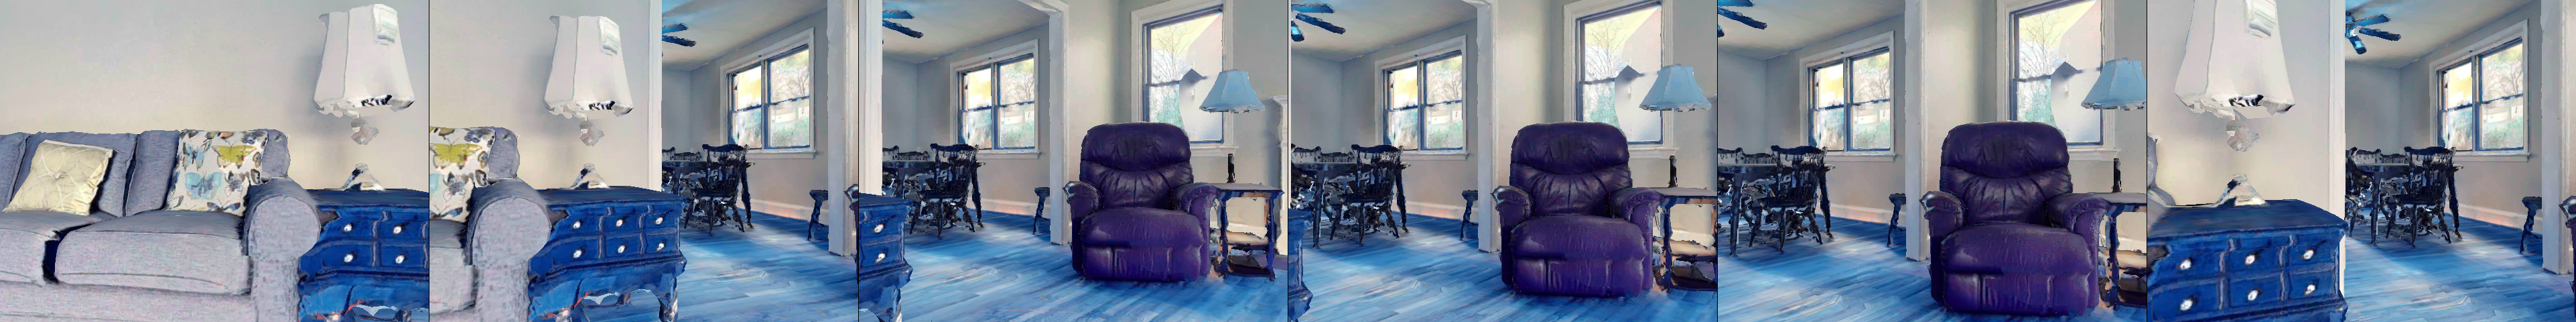

In [20]:
images = load_images("/srv/flash1/pputta7/projects/lm-nav/imgs/")
image = concatenate_images_horizontal(images, 1)
image

In [23]:
torch.set_grad_enabled(False)
# prepare image and text prompt, using the appropriate prompt template
# image = Image.open("/srv/flash1/pputta7/projects/lm-nav/imgs/img_3.png")
prompt = "A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>\nThis is a sequence of images from a navigation agent's perspective. Tell me what kind of room the agent is in. Is this a kitchen? ASSISTANT:"

inputs = processor(prompt, image, return_tensors="pt").to("cuda:0")

# autoregressively complete prompt
output = model.generate(**inputs, max_new_tokens=150)

print(processor.decode(output[0], skip_special_tokens=True))


A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER:  
This is a sequence of images from a navigation agent's perspective. Tell me what kind of room the agent is in. Is this a kitchen? ASSISTANT: The sequence of images shows a room with a variety of furniture and decor. The presence of a couch, chairs, a dining table, and what appears to be a kitchen counter or island suggests that this is a living room or a combined living and dining area. There are no clear indications of a kitchen in this sequence, such as a stove, oven, or sink, which are typical features of a kitchen. The room seems to be a space designed for relaxation and socializing, rather than for cooking.
